In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt, seaborn
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [3]:
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/sales_train.csv')
shop = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/shops.csv')
item = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/items.csv')
itemc = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/item_categories.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/test.csv')

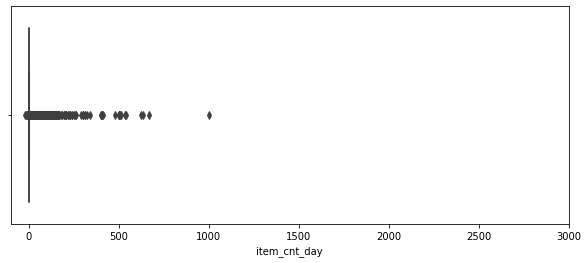

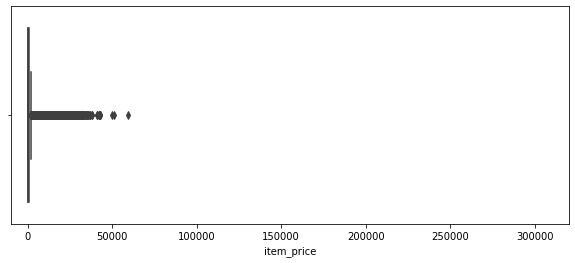

In [4]:
#date is changed from day.month.year to year-month-day 
train['date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')
train['year'] = train['date_block_num'].apply(lambda x: ((x//12) + 2013))
train['month'] = train['date_block_num'].apply(lambda x: ((x+1) % 12))

#delete outliers
train = train[train['item_cnt_day'] < 1001]
train = train[train['item_price'] < 300000]

#plot train data after delete outliers 
plt.figure(figsize=(10,4))
plt.xlim(-100,3000)
sns.boxplot(x=train['item_cnt_day'])

plt.figure(figsize=(10,4))
plt.xlim(-10000,320000)
sns.boxplot(x=train['item_price'])

#The data has item_price value less than zero, it's incorrect. We make item_price be median.
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train['item_price']<0,'item_price'] = median

In [5]:
# several shsops are duplicate, fix the train and test set
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [6]:
# Against shops.csv to encode (shop_id,shop_city,shop_type)
shop.loc[shop.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shop['city'] = shop['shop_name'].str.partition(' ')[0]
shop.loc[shop.city == '!Якутск', 'city'] = 'Якутск'
shop['shop_city'] = LabelEncoder().fit_transform(shop['city'])

shop['type'] = shop['shop_name'].apply(lambda x: 'МТРЦ' if 'МТРЦ' in x else 'ТРЦ' if 'ТРЦ' in x else 'ТРК' if 'ТРК' in x else 'ТЦ' if 'ТЦ' in x else 'ТK' if 'ТK' in x else 'none')
shop['shop_type'] = LabelEncoder().fit_transform(shop['type'])

shop = shop[['shop_id','shop_city','shop_type']]
shop.head()

,shop_id,shop_city,shop_type
0,0,29,0
1,1,29,4
2,2,0,4
3,3,1,2
4,4,2,4


In [7]:
itemc['split'] = itemc['item_category_name'].str.split('-')
itemc['type'] = itemc['split'].map(lambda x: x[0].strip())
itemc['type_code'] = LabelEncoder().fit_transform(itemc['type'])
# if subtype is nan then type
itemc['subtype'] = itemc['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
itemc['subtype_code'] = LabelEncoder().fit_transform(itemc['subtype'])
itemc = itemc[['item_category_id','type_code', 'subtype_code']]

itemc

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13
...,...,...,...
79,79,16,54
80,80,16,25
81,81,17,62
82,82,18,63


In [8]:
itemall = pd.merge(item,itemc,on='item_category_id',how='left')
del itemall['item_name']
itemall

,item_id,item_category_id,type_code,subtype_code
0,0,40,11,4
1,1,76,15,31
2,2,40,11,4
3,3,40,11,4
4,4,40,11,4
...,...,...,...,...
22165,22165,31,8,61
22166,22166,54,12,61
22167,22167,49,12,39
22168,22168,62,14,28


In [9]:
data = pd.merge(train,itemall,on='item_id',how='left')
data = pd.merge(data,shop,on='shop_id',how='left')
del data['date']

data

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,item_category_id,type_code,subtype_code,shop_city,shop_type
0,0,59,22154,999.00,1.0,2013,1,37,11,1,30,4
1,0,25,2552,899.00,1.0,2013,1,58,13,27,13,2
2,0,25,2552,899.00,-1.0,2013,1,58,13,27,13,2
3,0,25,2554,1709.05,1.0,2013,1,58,13,27,13,2
4,0,25,2555,1099.00,1.0,2013,1,56,13,3,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2935842,33,25,7409,299.00,1.0,2015,10,55,13,2,13,2
2935843,33,25,7460,299.00,1.0,2015,10,55,13,2,13,2
2935844,33,25,7459,349.00,1.0,2015,10,55,13,2,13,2
2935845,33,25,7440,299.00,1.0,2015,10,57,13,8,13,2


In [10]:
data_complete = data.groupby(['shop_id', 'item_id', 'date_block_num','year','month','item_category_id','type_code','subtype_code','shop_city','shop_type'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
data_complete.head()

,shop_id,item_id,date_block_num,year,month,item_category_id,type_code,subtype_code,shop_city,shop_type,item_cnt_month
0,2,27,0,2013,1,19,5,10,0,4,1.0
1,2,27,17,2014,6,19,5,10,0,4,1.0
2,2,30,2,2013,3,40,11,4,0,4,1.0
3,2,30,5,2013,6,40,11,4,0,4,1.0
4,2,30,15,2014,4,40,11,4,0,4,1.0


In [11]:
test['date_block_num'] = 34
test['year'] = 2015
test['month'] = 11
test = pd.merge(test,itemall,on='item_id',how='left')
test = pd.merge(test,shop,on='shop_id',how='left')
del test['ID']

test

,shop_id,item_id,date_block_num,year,month,item_category_id,type_code,subtype_code,shop_city,shop_type
0,5,5037,34,2015,11,19,5,10,3,3
1,5,5320,34,2015,11,55,13,2,3,3
2,5,5233,34,2015,11,19,5,10,3,3
3,5,5232,34,2015,11,23,5,16,3,3
4,5,5268,34,2015,11,20,5,11,3,3
...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,34,2015,11,55,13,2,20,4
214196,45,16188,34,2015,11,64,14,42,20,4
214197,45,15757,34,2015,11,55,13,2,20,4
214198,45,19648,34,2015,11,40,11,4,20,4


In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import gc

In [13]:
X_train = data_complete[data_complete.date_block_num < 33].drop(['item_cnt_month'], axis=1)
X_train = np.expand_dims(data_complete.values[:, :-1], axis=2)
Y_train = data_complete[data_complete.date_block_num < 33]['item_cnt_month']
Y_train = data_complete.values[:, -1:]
X_valid = data_complete[data_complete.date_block_num == 33].drop(['item_cnt_month'], axis=1)
X_valid = np.expand_dims(data_complete.values[:, :-1], axis=2)
Y_valid = data_complete[data_complete.date_block_num == 33]['item_cnt_month']
Y_valid = data_complete.values[:, -1:]
X_test = test
X_test = np.expand_dims(test.values[:, :], axis=2)

In [26]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
MaxMin_scl = MinMaxScaler()
MaxMin_scl = MaxMin_scl.fit(X_train)
MaxMin_train_scl = MaxMin_scl.transform(X_train)
MaxMin_valid_scl = MaxMin_scl.transform(X_valid)
MaxMin_test_scl = MaxMin_scl.transform(X_test)

In [25]:
pd.DataFrame(MaxMin_train_scl).head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.001218,0.00000,0.0,0.090909,0.228916,0.263158,0.15625,0.0,1.0
1,0.0,0.001218,0.53125,0.5,0.545455,0.228916,0.263158,0.15625,0.0,1.0
2,0.0,0.001353,0.06250,0.0,0.272727,0.481928,0.578947,0.06250,0.0,1.0
3,0.0,0.001353,0.15625,0.0,0.545455,0.481928,0.578947,0.06250,0.0,1.0
4,0.0,0.001353,0.46875,0.5,0.363636,0.481928,0.578947,0.06250,0.0,1.0


In [14]:
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(10,1),return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(8))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 10, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 7,697
Trainable params: 7,697
Non-trainabl

Epoch 1/20
771/771 [==============================] - 49s 61ms/step - loss: 72.1774 - mse: 72.1774 - val_loss: 50.7749 - val_mse: 50.7749
Epoch 2/20
771/771 [==============================] - 46s 60ms/step - loss: 72.1023 - mse: 72.1023 - val_loss: 50.7560 - val_mse: 50.7560
Epoch 3/20
771/771 [==============================] - 47s 61ms/step - loss: 72.1001 - mse: 72.1001 - val_loss: 50.7593 - val_mse: 50.7593
Epoch 4/20
771/771 [==============================] - 47s 61ms/step - loss: 72.0975 - mse: 72.0975 - val_loss: 50.7671 - val_mse: 50.7671
Epoch 5/20
771/771 [==============================] - 46s 60ms/step - loss: 72.0984 - mse: 72.0984 - val_loss: 50.7572 - val_mse: 50.7572
Optimal Epoch: {} 1
Train Score: 72.10234069824219, Validation Score: 50.755950927734375


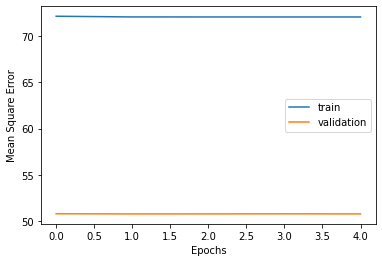

<Figure size 432x288 with 0 Axes>

In [27]:
LSTM_PARAM = {"batch_size":2048,
              "verbose":1,
              "epochs":20}

    
callbacks_list=[EarlyStopping(monitor="val_loss",min_delta=.001, patience=3,mode='auto')]
hist = model_lstm.fit(MaxMin_train_scl, Y_train,validation_data=(MaxMin_valid_scl, Y_valid),callbacks=callbacks_list, **LSTM_PARAM)
pred = model_lstm.predict(MaxMin_test_scl)

# Model Evaluation
best = np.argmin(hist.history["val_loss"])
print("Optimal Epoch: {}",best)
print("Train Score: {}, Validation Score: {}".format(hist.history["loss"][best],hist.history["val_loss"][best]))

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()
plt.savefig("Train and Validation MSE Progression.png")

In [28]:
submission = pd.DataFrame(pred,columns=['item_cnt_month'])
submission.to_csv('/content/gdrive/MyDrive/Colab Notebooks/lstm_sub_v3.csv',index_label='ID')

In [29]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lstm_sub_v3.csv')
df

,ID,item_cnt_month
0,0,2.251290
1,1,2.250470
2,2,2.251236
3,3,2.251877
4,4,2.251330
...,...,...
214195,214195,2.247768
214196,214196,2.251889
214197,214197,2.248001
214198,214198,2.247956


In [18]:
from xgboost import XGBRegressor
from xgboost import plot_importance
import time

In [19]:
X_train = data_complete[data_complete.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data_complete[data_complete.date_block_num < 33]['item_cnt_month']
X_valid = data_complete[data_complete.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data_complete[data_complete.date_block_num == 33]['item_cnt_month']
X_test = test

In [20]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=20)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[12:44:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8.39598	validation_1-rmse:6.99632
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:8.17485	validation_1-rmse:6.72779
[2]	validation_0-rmse:7.98985	validation_1-rmse:6.5171
[3]	validation_0-rmse:7.83251	validation_1-rmse:6.35044
[4]	validation_0-rmse:7.71121	validation_1-rmse:6.25162
[5]	validation_0-rmse:7.59797	validation_1-rmse:6.14375
[6]	validation_0-rmse:7.50848	validation_1-rmse:6.07877
[7]	validation_0-rmse:7.43058	validation_1-rmse:6.01062
[8]	validation_0-rmse:7.35977	validation_1-rmse:5.96658
[9]	validation_0-rmse:7.30681	validation_1-rmse:5.918
[10]	validation_0-rmse:7.25965	validation_1-rmse:5.89419
[11]	validation_0-rmse:7.21502	validation_1-rmse:5.88474
[12]	validation_0-rmse:7.1808	validation_1-

276.4450144767761

In [21]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('/content/gdrive/MyDrive/Colab Notebooks/xgb_submission_v2.csv', index=False)

In [22]:
dl = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/xgb_submission_v2.csv')
dl

,ID,item_cnt_month
0,0,0.778821
1,1,1.371426
2,2,0.797007
3,3,1.222976
4,4,1.398487
...,...,...
214195,214195,1.424668
214196,214196,1.203492
214197,214197,1.071009
214198,214198,1.157579
